In [1]:
from scipy.stats import beta


lower_bound = 0.8
upper_bound = 0.9
cumulative_probability = 0.99


a = beta.ppf((1 + cumulative_probability) / 2, lower_bound, upper_bound)
b = beta.ppf((1 - cumulative_probability) / 2, lower_bound, upper_bound)
print(a,b)

0.9965010617673402 0.0014898133487040337


In [51]:
import torch
import pyro
import pyro.distributions as dist
from chirho.observational.handlers import condition
import matplotlib.pyplot as plt

tensor(0.0780) tensor(0.9400)


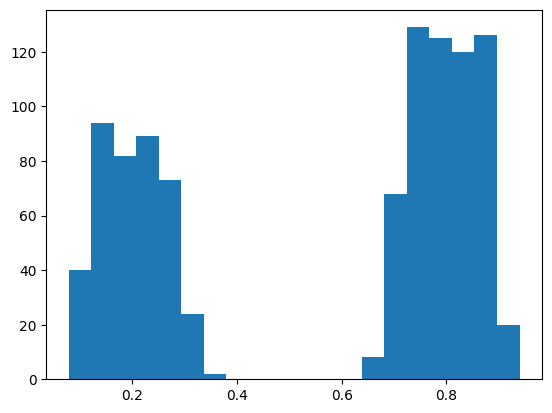

tensor(0.0900) tensor(0.9240)


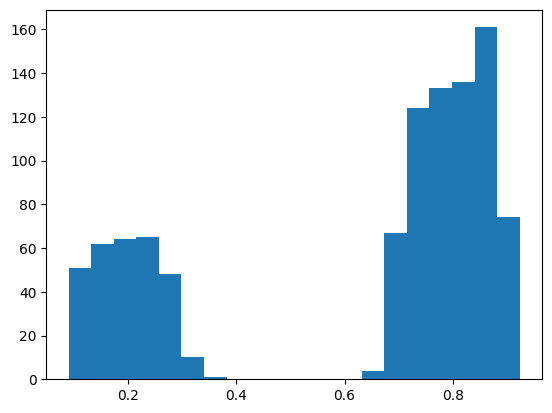

In [53]:
def imprecise_chain():
    Aprob = pyro.sample("Aprob", dist.Uniform(.7,.9))
    A = pyro.sample("A", dist.Bernoulli(Aprob)) 
    
    BprobA = pyro.sample("BprobA", dist.Uniform(.7,.9))
    BprobnA = pyro.sample("BprobnA", dist.Uniform(.1,.3)
                          )
    B = pyro.sample("B", dist.Bernoulli(A * BprobA + (1 - A) * BprobnA))
    
    CprobB = pyro.sample("CprobB", dist.Uniform(.7,.9))
    CprobnB = pyro.sample("CprobnB", dist.Uniform(.1,.3))
    C = pyro.sample("C", dist.Bernoulli(B * CprobB + (1 - B) * CprobnB))
 
    DprobC = pyro.sample("DprobC", dist.Uniform(.7,.9))
    DprobnC = pyro.sample("DprobnC", dist.Uniform(.1,.3))
    
    with pyro.plate("d_runs", 500):
        D = pyro.sample("D", dist.Bernoulli(C * DprobC + (1 - C) * DprobnC))
        

with pyro.poutine.trace() as prior:
    with pyro.plate("prior", 1000):
        imprecise_chain()
 

d_prior = torch.mean(prior.trace.nodes['D']['value'], dim=0)
print(torch.min(d_prior), torch.max(d_prior))        
plt.hist(d_prior, bins=20)
plt.show()


conditioned_imprecise_chain = condition(imprecise_chain, data={"A": torch.tensor([1.])})

with pyro.poutine.trace() as posterior:
    with pyro.plate("prior", 1000):
            conditioned_imprecise_chain()

d_posterior = torch.mean(posterior.trace.nodes['D']['value'], dim=0)
print(torch.min(d_posterior), torch.max(d_posterior))        
plt.hist(d_posterior, bins=20)
plt.show()
